In [23]:
import matplotlib.pyplot as plt
from skimage.io import imread

#input_name="D:\\images\\ABRF LMRG Image Analysis Study\\nuclei\\nuclei1_out_c00_dr90_image.tif" 
input_name="D:\\images\\ABRF LMRG Image Analysis Study\\nuclei\\nuclei4_out_c90_dr10_image.tif"

In [24]:
import tifffile
from tifffile import TiffFile
from tifffile.tifffile import imagej_description_metadata

def open_ij3D(filename):
    """ open imagej 3D image and read spacings from meta data

    Args:
        filename (string): Full locaton of file to open

    Returns:
        [numpy array, float, float, float]: returns numpy array with data and x, y and z voxel size
    """
    tif = TiffFile(filename)
    tags = tif.pages[0].tags
    x_resolution = tags['XResolution'].value
    y_resolution = tags['YResolution'].value

    x_size = x_resolution[1]/x_resolution[0]
    y_size = y_resolution[1]/y_resolution[0]

    ij_description = tags['ImageDescription'].value
    ij_description_metadata = imagej_description_metadata(ij_description)
    z_size=ij_description_metadata['spacing']

    return tif.asarray(), x_size, y_size, z_size

In [25]:
input_image, voxel_size_x_, voxel_size_y_, voxel_size_z_ = open_ij3D(input_name)
print(input_image.shape)
print(voxel_size_x_, voxel_size_y_, voxel_size_z_)
voxel_size_x=1.
voxel_size_y=1.
voxel_size_z=(1./voxel_size_x_)*voxel_size_z_
print(voxel_size_x, voxel_size_y, voxel_size_z)

(100, 258, 258)
0.1238060147933331 0.1238060147933331 0.2
1.0 1.0 1.6154304000000002


In [26]:
import pyclesperanto_prototype as cle

# select a specific OpenCL / GPU device and see which one was chosen
cle.select_device('RTX')

<GeForce RTX 3090 on Platform: NVIDIA CUDA (2 refs)>

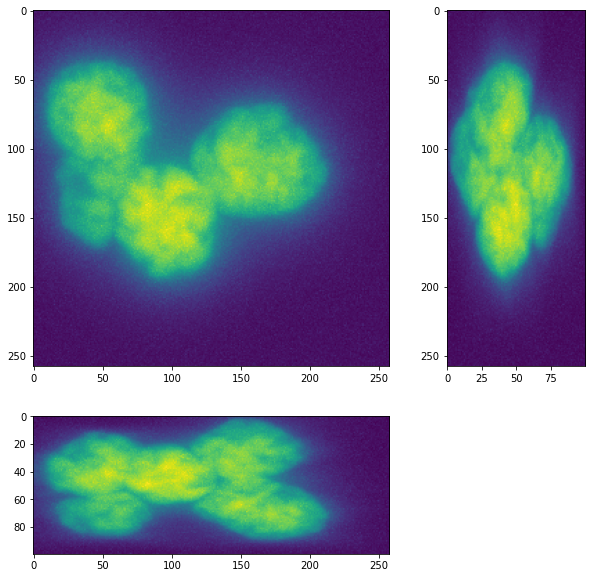

In [27]:
input_gpu = cle.push(input_image)
from matplotlib import gridspec

def show(image_to_show, labels=False):
    """
    This function generates three projections: in X-, Y- and Z-direction and shows them.
    """
    fig=plt.figure(figsize=(10,10))

    spec=gridspec.GridSpec(ncols=2, nrows=2, height_ratios=[image_to_show.shape[1],image_to_show.shape[0]], width_ratios=[image_to_show.shape[1],image_to_show.shape[0]])

    ax0=fig.add_subplot(spec[0])
    ax1=fig.add_subplot(spec[1])
    ax2=fig.add_subplot(spec[2])

    projection_x = cle.maximum_x_projection(image_to_show)
    projection_y = cle.maximum_y_projection(image_to_show)
    projection_z = cle.maximum_z_projection(image_to_show)

    ax0.imshow(projection_z)
    ax1.imshow(projection_x)
    ax2.imshow(projection_y)
    #cle.imshow(projection_z, plot=axs[0], labels=labels)
    #cle.imshow(projection_y, plot=axs[1], labels=labels)
    #cle.imshow(projection_z, plot=axs[2], labels=labels)

show(input_gpu)

(161, 258, 258)


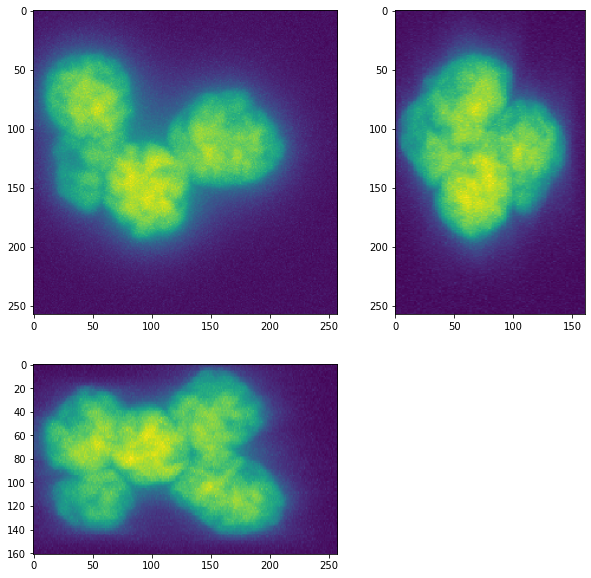

In [28]:
resampled = cle.create([int(input_gpu.shape[0] * voxel_size_z), int(input_gpu.shape[1] * voxel_size_y), int(input_gpu.shape[2] * voxel_size_x)])
cle.scale(input_gpu, resampled, factor_x=voxel_size_x, factor_y=voxel_size_y, factor_z=voxel_size_z, centered=False)

show(resampled)
print(resampled.shape)

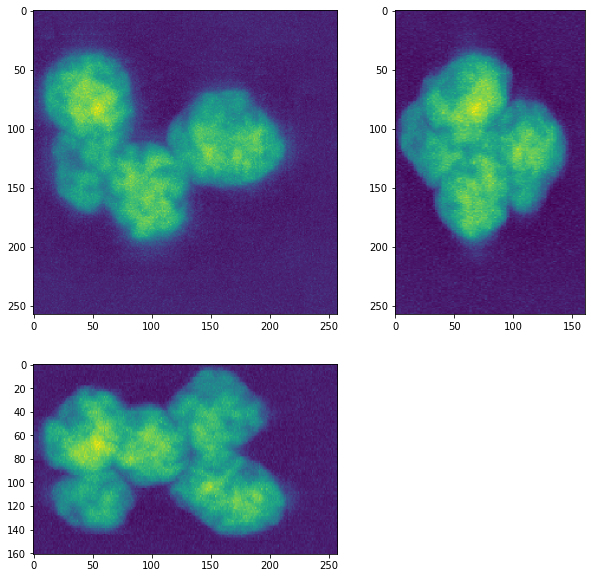

In [30]:
background_subtracted = cle.top_hat_box(resampled, radius_x=25, radius_y=25, radius_z=25)
#background_subtracted = resampled
show(background_subtracted)

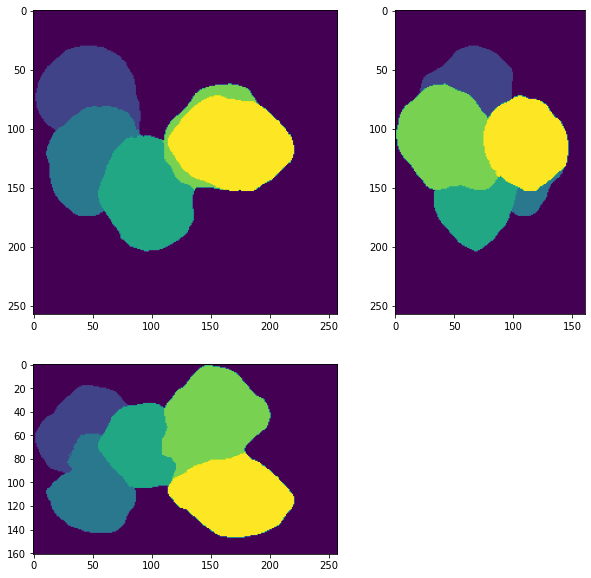

In [41]:
segmented = cle.voronoi_otsu_labeling(background_subtracted, spot_sigma=20, outline_sigma=2)
show(segmented, labels=True)

In [42]:
# start napari
import napari
viewer = napari.Viewer()

# show images
viewer.add_image(cle.pull(resampled))
viewer.add_labels(cle.pull(segmented))

<Labels layer 'Labels' at 0x1fde1183a00>

Exception in callback BaseAsyncIOLoop._handle_events(5636, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(5636, 1)>
Traceback (most recent call last):
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-packages\tornado\platform\asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-packages\zmq\eventloop\zmqstream.py", line 448, in _handle_events
    self._handle_recv()
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-packages\zmq\eventloop\zmqstream.py", line 477, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-pac